##Requirements

Calling tensorflow, matplotlib, pandas, numpy and other libraries for prediction and visualization aid.

In [106]:
%tensorflow_version 2.x
%matplotlib inline
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: astunparse, absl-py, keras-nightly, wrapt, numpy, typing-extensions, tensorflow-estimator, termcolor, gast, h5py, protobuf, grpcio, keras-preprocessing, wheel, tensorboard, flatbuffers, six, opt-einsum, google-pasta
Required-by: kapre


In [107]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

##Function for making MAT data usable for prediction

The data that we used here is a part of NASA's Prognostics Center of Excellence Repository. It can be accessed at the following link: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#battery
The data files are in .mat format. We required a function that can convert these highly branched .mat data to simpler dataframe that can be used for learning the patterns from.

In [108]:
def load_data(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  capacity_ = []
  counter = 0
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      capacity_.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  return pd.DataFrame(data=capacity_,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])

In [109]:
df = load_data('B0007')

Total data in dataset:  616


For the task of training RNN, we need data cycles that have capacity attribute in them. Only "Discharge" cycles have capacity attribute in them. So, Out of 616 total cycles including Charge, Discharge and Impedance, only those of type Discharge are going to be used here.

In [9]:
df

,cycle,ambient_temperature,datetime,capacity
0,1,24,2008-04-02 15:25:41,1.891052
1,2,24,2008-04-02 19:43:48,1.880637
2,3,24,2008-04-03 00:01:06,1.880663
3,4,24,2008-04-03 04:16:37,1.880771
4,5,24,2008-04-03 08:33:25,1.879451
...,...,...,...,...
163,164,24,2008-05-26 10:44:38,1.406171
164,165,24,2008-05-26 15:30:43,1.406336
165,166,24,2008-05-26 20:21:04,1.400455
166,167,24,2008-05-27 15:52:41,1.421787


Now we used this simpler dataframe in order to prepare training and testing sets for validation of the model in further steps.
Here we intend to use an LSTM model, so only getting the temporal series of capacity data with cycle sequence can also get us results. In this specific case, the battery capacity data is used to predict the capacity in the following cycles using the data of the first few cycles in such a way that we can know when the battery threshold is reached and estimate the missing cycles to reach the end of the battery life.

In [110]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = df[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
dataset

,cycle,capacity
0,1,1.891052
1,2,1.880637
2,3,1.880663
3,4,1.880771
4,5,1.879451
...,...,...
163,164,1.406171
164,165,1.406336
165,166,1.400455
166,167,1.421787


Now We need to define the Train-Test Split:
Out of the 168 cycles we can train model on some of the earlier capacity-cycle data and then check the results on remaining capacity-cycle data as our test data.

We shall try it for a range of values from using a train test split of 50-118, 55-113, and so on untill 75-83. We shall store them in a dictionary for each split case wise.

Here train is intentioanlly smaller subset because we want to take a part of battery data and predict for its failure in future as long as possible. Here failure means Battery capacity below 80%. 

In [111]:
sc=MinMaxScaler(feature_range=(0,1))
data_dict = {}
for i in range(50, 80, 5):
  data_train = dataset[(dataset['cycle']<i)]
  data_set_train = data_train.iloc[:,1:2].values
  data_test = dataset[(dataset['cycle']>=i)]
  data_set_test = data_test.iloc[:,1:2].values
  data_set_train=sc.fit_transform(data_set_train)
  data_set_test=sc.transform(data_set_test)
  data_dict['data_train' + str(i)], data_dict['data_set_train' + str(i)], data_dict['data_test' + str(i)], data_dict['data_set_test' + str(i)] = data_train, data_set_train, data_test, data_set_test

In [48]:
data_dict['data_set_test75']

array([[-0.02230993],
       [-0.06760622],
       [-0.0682697 ],
       [-0.04787779],
       [-0.08791367],
       [-0.13133591],
       [-0.15140169],
       [-0.15393325],
       [-0.15015707],
       [-0.17472   ],
       [-0.21750686],
       [-0.23739206],
       [-0.23613216],
       [-0.23785717],
       [-0.25947325],
       [ 0.15211891],
       [-0.11129284],
       [-0.15426918],
       [-0.19653389],
       [-0.24134469],
       [-0.26048174],
       [-0.28169033],
       [-0.30423828],
       [-0.32417495],
       [-0.34689928],
       [-0.34497883],
       [-0.36596994],
       [-0.38951551],
       [-0.36709281],
       [-0.32517719],
       [-0.36583895],
       [-0.38900584],
       [-0.43033603],
       [-0.45557791],
       [-0.45079162],
       [-0.45257237],
       [-0.49569504],
       [-0.51895693],
       [-0.5182625 ],
       [-0.51756809],
       [-0.5393099 ],
       [-0.56127255],
       [-0.5823167 ],
       [-0.58249785],
       [-0.58106379],
       [-0

Now we need to convert this train split into time sequence data that is important for LSTM. What we shall do is, for each capacity value use past few capacity values as its features. That way X_train will be array of past few capacities and y_train will be array of current capacity.

Here we again allow performance to decide how many previous capacity values should be features in X_train for current capacity value in y_train.

In [112]:
train = {}
#take the last 10t to predict 10t+1
for k in range(50, 80, 5):
  for j in range(10, 30, 5):
    X_train=[]
    y_train=[]
    for i in range(j,k-1):
      X_train.append(data_dict['data_set_train'+ str(k)] [i-j:i,0])
      y_train.append(data_dict['data_set_train'+ str(k)][i,0])
    X_train,y_train=np.array(X_train),np.array(y_train)
    X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    train['X_train' + str(j) + '_' + str(k)], train['y_train' + str(j) + '_' + str(k)] = X_train, y_train

Now there is train data corresponding to each split (50, 55, ..,75) and each selection of features (10, 15, .., 25).

In [53]:
train['X_train25_75']

array([[[1.        ],
        [0.95633261],
        [0.95644012],
        ...,
        [0.91596567],
        [0.91257195],
        [0.91455096]],

       [[0.95633261],
        [0.95644012],
        [0.95689389],
        ...,
        [0.91257195],
        [0.91455096],
        [0.86818433]],

       [[0.95644012],
        [0.95689389],
        [0.95135949],
        ...,
        [0.91455096],
        [0.86818433],
        [0.8699513 ]],

       ...,

       [[0.5357689 ],
        [0.68145799],
        [0.68408604],
        ...,
        [0.10644394],
        [0.08665058],
        [0.06246199]],

       [[0.68145799],
        [0.68408604],
        [0.61927088],
        ...,
        [0.08665058],
        [0.06246199],
        [0.04078416]],

       [[0.68408604],
        [0.61927088],
        [0.57820153],
        ...,
        [0.06246199],
        [0.04078416],
        [0.02048362]]])

This does result in number of rows reduced by number of features but now we have sequential data of capacities.

##Neural Network building

Calling the necessary tensorflow models, layers and optimizers.

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

Here we used LSTM( long short term memory) artificial recurrent neural network architecture. Its difference from the standard neural networks is that it has feedback capabilities unlike their feedforward connections. Most of the RNN's are capable of using feedback or memory advantage to optimize their learning but a standard RNN may find it difficult to utilize a very distant learning in the network. This is called <b>Long Term Dependency issue</b>.

 
A Long Short Term Memory (<b>LSTM</b>) RNN is capable of dealing with long term dependencies as it is innate nature of its layer architecture. It has a bit more complex layer structure than a standard RNN which helps it become more selective at decision making and learning from data.

Let us now define different models for different train sets since input size differes for each of them. We can again save them in a dictionary. 

In [117]:
model = {}
for i in range(50, 80, 5):
  for j in range(10, 30, 5):
    regress = Sequential()
    regress.add(LSTM(units=300, return_sequences=True, input_shape=(train['X_train'+str(j)+'_'+str(i)].shape[1],1)))
    regress.add(Dropout(0.3))
    regress.add(LSTM(units=300, return_sequences=True))
    regress.add(Dropout(0.3))
    regress.add(LSTM(units=300, return_sequences=True))
    regress.add(Dropout(0.3))
    regress.add(LSTM(units=300))
    regress.add(Dropout(0.3))
    regress.add(Dense(units=1))
    regress.compile(optimizer='adam',loss='mean_squared_error')
    model['regress'+str(j)+'_'+str(i)] = regress

In [67]:
model['regress10_50']

##Train

Now here we have 24 models to train on 24 sets of X-train and y_train.

In [118]:
for i in range(50, 80, 5):
  for j in range(10, 30, 5):
    model['regress'+str(j)+'_'+str(i)].fit(train['X_train'+str(j)+'_'+str(i)],train['y_train'+str(j)+'_'+str(i)],epochs=220,batch_size=25)

Streaming output truncated to the last 5000 lines.
Epoch 141/220
3/3 [==============================] - 0s 124ms/step - loss: 0.0107
Epoch 142/220
3/3 [==============================] - 0s 126ms/step - loss: 0.0080
Epoch 143/220
3/3 [==============================] - 0s 118ms/step - loss: 0.0094
Epoch 144/220
3/3 [==============================] - 0s 124ms/step - loss: 0.0104
Epoch 145/220
3/3 [==============================] - 0s 120ms/step - loss: 0.0073
Epoch 146/220
3/3 [==============================] - 0s 120ms/step - loss: 0.0075
Epoch 147/220
3/3 [==============================] - 0s 128ms/step - loss: 0.0103
Epoch 148/220
3/3 [==============================] - 0s 119ms/step - loss: 0.0086
Epoch 149/220
3/3 [==============================] - 0s 121ms/step - loss: 0.0097
Epoch 150/220
3/3 [==============================] - 0s 120ms/step - loss: 0.0129
Epoch 151/220
3/3 [==============================] - 0s 116ms/step - loss: 0.0094
Epoch 152/220
3/3 [============================

##Test prep

Preparing the test data.

Corresponding to each split and feature count selection we have different test sets. We shall first take different subsets (inputs) of total 168 row initial capacity data due to different splits.

In [119]:
Inputs = {} 
for i in range(50, 80, 5):
  data_total = pd.concat((data_dict['data_train'+str(i)]['capacity'], data_dict['data_test'+str(i)]['capacity']),axis=0)
  for j in range(10, 30, 5):
    inputs=data_total[len(data_total)-len(data_dict['data_test'+str(i)])-j:].values
    inputs=inputs.reshape(-1,1)
    inputs=sc.transform(inputs)
    Inputs['inputs'+str(j)+'_'+str(i)] = inputs

In [98]:
Inputs['inputs15_50'].shape

(134, 1)

##Testing

Now in the test dictionary we can add different test datasets corresponding to different split and feature count combinations.

In [135]:
test = {}
for k in range(50, 80, 5):
  for j in range(10, 30, 5):
    X_test=[]
    for i in range(j,len(Inputs['inputs'+str(j)+'_'+str(k)])):
      X_test.append(Inputs['inputs'+str(j)+'_'+str(k)][i-j:i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    test['test'+str(j)+'_'+str(k)] = X_test

Now we can get the performance results in terms of Root Mean Square Error and R2 Score for each test set and model combination. The one with best reults will be plotte later to check its performance visually.

In [138]:
for i in range(50, 80, 5):
  for j in range(10, 30, 5):
    pred=model['regress'+str(j)+'_'+str(i)].predict(test['test'+str(j)+'_'+str(i)])
    print(pred.shape)
    pred=sc.inverse_transform(pred)
    pred=pred[:,0]
    tests=data_dict['data_test'+str(i)].iloc[:,1:2]
    print('Performance of model with {} time features and {} rowed training instances:'.format(str(j), str(i)))
    rmse = np.sqrt(mean_squared_error(tests, pred))
    print('Test RMSE: %.3f' % rmse)
    r2 = metrics.r2_score(tests,pred)
    print('Test r2 score: %.3f' % r2)
    print('\n')

(119, 1)
Performance of model with 10 time features and 50 rowed training instances:
Test RMSE: 0.024
Test r2 score: 0.947


(119, 1)
Performance of model with 15 time features and 50 rowed training instances:
Test RMSE: 0.472
Test r2 score: -18.583


(119, 1)
Performance of model with 20 time features and 50 rowed training instances:
Test RMSE: 0.026
Test r2 score: 0.940


(119, 1)
Performance of model with 25 time features and 50 rowed training instances:
Test RMSE: 0.111
Test r2 score: -0.088


(114, 1)
Performance of model with 10 time features and 55 rowed training instances:
Test RMSE: 0.056
Test r2 score: 0.672


(114, 1)
Performance of model with 15 time features and 55 rowed training instances:
Test RMSE: 0.016
Test r2 score: 0.974


(114, 1)
Performance of model with 20 time features and 55 rowed training instances:
Test RMSE: 0.027
Test r2 score: 0.921


(114, 1)
Performance of model with 25 time features and 55 rowed training instances:
Test RMSE: 0.022
Test r2 score: 0.951

Since, best performance is shown by the hyperparameter selection of 55 train examples split and 15 training data features.

In [139]:
X_test=[]
for i in range(15,len(Inputs['inputs15_55'])):
    X_test.append(Inputs['inputs15_55'][i-15:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [140]:
pred=model['regress15_55'].predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_dict['data_test55'].iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
r2 = metrics.r2_score(tests,pred)
print('Test r2 score: %.3f' % r2)

(114, 1)
Test RMSE: 0.016
Test r2 score: 0.974


The model was able to predict the remaining useful life for battery test dataset with  a root mean square error of 0.016 cycles and the R2 score is attained is reasonably well 97.4%.

##Visual rep of results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

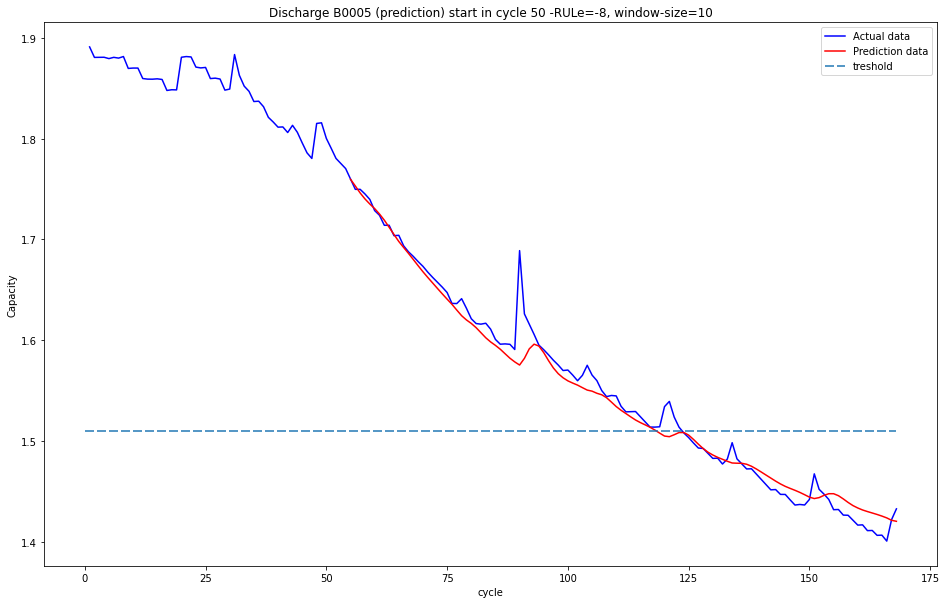

In [141]:
ln = len(data_dict['data_train55'])
data_dict['data_test55']['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_pre = data_dict['data_test55'].loc[(data_dict['data_test55']['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_pre['cycle'],plot_pre['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.51, 1.51],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

Prediction on the Test set and error calculation

In [142]:
pred=0
Afil=0
Pfil=0
a=data_dict['data_test55']['capacity'].values
b=data_dict['data_test55']['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.51:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.51:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 123
The prediction fail at cycle number: 118
The error of RUL= -5 Cycle(s)


We have assumed the End of Life for a battery to be when the State of Charge goes below 80%, which is 1.51 Ahr for the battery used here.

On the test data battery, this model was able to predict the failure( State of charge hitting 20%) with an error of 5 cycles. The fact to be observed is that the model was capable to pre-predict the failure(End of Life) for battery which is very important to avoid complications and improve the quality of Predictive Maintenace feature for this (RUL)Remaining Useful Life Prediction Task.  